In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import itertools
sys.path.append("/mnt/ssd/NMRlipids_VI-NewIonModel/scripts/")
import calcOrderParameters as cop
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
exper_fname = "/mnt/ssd/NMRlipids_VI-NewIonModel/Data/POPC/exp/POPC_Order_Parameters_Experiments_all.dat"

sim_l14_fname = "NpT/sim0-3_0mM_TIP3p_ref_noIons_300K/OrdPars.dat"
sim_ecc_fname1 = "NpT/sim22a_0mM_NaCl_SPCE_non-tail-atoms_q-sc_0.80_sig-sc_0.89_noIons-ref_300K/OrdPars.dat"
#sim_ecc_fname2 = "NpT/sim22a_0mM_NaCl_OPC4_non-tail-atoms_q-sc_0.80_sig-sc_0.89_noIons-ref/OrdPars.dat"
#sim_ecc_fname3 = "NpT/sim22a_0mM_NaCl_SPCE_non-tail-atoms_q-sc_0.80_sig-sc_0.89_noIons-ref/OrdPars.dat"

fnames = [exper_fname, sim_l14_fname, sim_ecc_fname1] #, sim_ecc_fname2, sim_ecc_fname3] 

models = []
for fname in fnames:
    model = cop.parse_op_input(fname)
    models.append(model)


In [3]:
# define mapping for ordering of my OP labels
def popc_order(s):
    groups = ('gamma', 'beta', 'alpha', 'g3', 'g2', 'g1') #, 'palmitoyl', 'oleoyl')
    if not s.startswith(groups):
        return 2*(len(groups)+1)
    else:
        for i,g in enumerate(groups):
            if s.startswith(g):
                if g.endswith("a"):
                    return 2*i
                else:
                    return 2*(i+1)
    
refmodel = models[0]
ax_x_labels = refmodel.keys()
ax_x_labels.sort()
ax_x_labels = sorted(ax_x_labels, key=popc_order)

xlabels = (r'$\gamma$', r'$\beta$', r'$\alpha$', r'$g_3$', r'$g_2$', r'$g_1$')

Plotting figure 1

taken from GNUplot script:
"""plot \
     "../../Data/POPC/no-ions/Kucerka_POPC_ULV_form-f/POPC_ULV_303K_in0D.xff" using 1:2:3 with yerrorbars title 'experiment 303K' ls ls_exp , \
     "../../Data/POPC/no-ions/Lipid14/sim22a_0mM_NaCl_OPC3_non-tail-atoms_q-sc_0.80_sig-sc_0.89_noIons-ref_300K/Form_Factor_From_Simulation.dat" using 1:(2.05/3.8 * $2) title 'ECC-POPC 300K' with lines ls ls_eccl17 , \
     "../../Data/POPC/no-ions/Lipid14/sim0-3_0mM_TIP3p_ref_noIons_300K/Form_Factor_From_Simulation.dat" using 1:(2.3/3.8 * $2) title 'Lipid14 300K' with lines ls ls_l14, \
"""

In [4]:
form_fs_files = ["../../../Data/POPC/no-ions/Kucerka_POPC_ULV_form-f/POPC_ULV_303K_in0D.xff",
                 "../../../Data/POPC/no-ions/Lipid14/sim0-3_0mM_TIP3p_ref_noIons_300K/Form_Factor_From_Simulation.dat",
                 "../../../Data/POPC/no-ions/Lipid14/sim22a_0mM_NaCl_SPCE_non-tail-atoms_q-sc_0.80_sig-sc_0.89_noIons-ref_300K/Form_Factor_From_Simulation.dat"
                ]

form_fs = []
for f in form_fs_files:
    form_fs.append(np.loadtxt(f))

/usr/lib64/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/usr/lib64/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


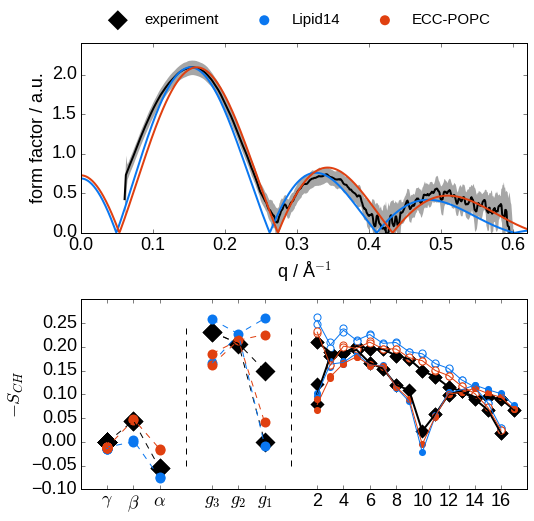

In [5]:
font = {'family' : 'Liberation Sans',
        'style'  : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

fig, axs = plt.subplots(nrows=2, ncols=1, sharex='none', figsize=[8,8], dpi=200)
fig.subplots_adjust(hspace=0.35)
ax = axs[0]
# add some text for labels, title and axes ticks
#ax.set_xlabel(r'POPC Headgroup and tail order parameters')
ax.set_xlim([0.0, 0.62])
ax.set_ylim([0.0, 2.4])

ax.set_xlabel(ur"q / \u00c5$^{-1}$")
ax.set_ylabel(r'form factor / a.u.')


legends = ['experiment', 'Lipid14', r'ECC-POPC'] #, r'ECC-POPC 17, OPC4', r'ECC-POPC 17, SPC/E'] #, 'scaled Oxy. sigmas 0.90 0mM', 'scaled OCH headgr. sigmas 0.94 0mM',
           #'scaled 0.75 Oxy. sigmas 0.90 0mM', 'scaled 0.75 Oxy. sigmas 0.90 0mM NpAT']
colours = ['black', '#0a77f0',  '#e04010',  '#DE4578',  '#BB5487']  # zip() truncates the to the shortest list

for (model, legend, colour) in zip(form_fs, legends, colours):
    linew = 2.0
    if legend.startswith('exp'):
        f_exp = model
        N = 5
        f_exp = np.convolve(f_exp[:,1], np.ones((N,))/N, mode='same')
        f_err = abs(model[:,1]-f_exp)
        #f_err = np.zeros(f_err.shape)
        f_err = np.convolve(f_err, np.ones((N,))/N, mode='same')*2.0
        for f in [model]:
            #ax.errorbar(f[:,0], f[:,1], f[:,2], c=colour, lw=plotlinew, ls="-", label=point_label)
            ax.plot(f[:,0], f_exp, c=colour, ls="-", lw=linew)
            ax.fill_between(f[:,0], f_exp-f[:,2]*1.5-f_err, f_exp+f[:,2]*1.5+f_err, color=colour, alpha=0.35, lw=0)
            #ax.plot(f[:,0], f[:,1], c=colour, lw=plotlinew, ls="-", label=point_label)
        f_exp_max = f_exp.max()
    else:
        f = model
        if f_exp_max:
            f[:,1] *= f_exp_max/f[:,1].max()
        ax.plot(f[:,0], f[:,1], color=colour, ls="-", lw=linew)

        
# choline-glycerol separator
ax.vlines(len(xlabels), -0.05, 0.25, linestyles='dashed')
# glycerol-tails separator
ax.vlines(2*len(xlabels)+2, -0.05, 0.25, linestyles='dashed')


ax.legend(bbox_transform=plt.gcf().transFigure,
             bbox_to_anchor=(0.86, 1.02), 
             ncol=3, 
             frameon=False,
             fontsize='small')

#plt.savefig("Order-parameters_exp-L14-ECCL17_q80_sig89.pdf", dpi=200, bbox_inches='tight')
#plt.show()


#font = {'family' : 'Liberation Sans',
#        'style'  : 'normal',
#        'weight' : 'normal',
#        'size'   : 18}
#
#matplotlib.rc('font', **font)
#
#fig, ax = plt.subplots(nrows=1, ncols=1, sharex="all", figsize=[8,4], dpi=200)

# add some text for labels, title and axes ticks
#ax.set_xlabel(r'POPC Headgroup and tail order parameters')
ax = axs[1]
ax.set_ylabel(r'$-S_{CH}$')
ax.set_xlim([-2,32])
ax.set_ylim([-0.1,0.3])
r1 = range(0, 2*len(xlabels)+1, 2)
r1.remove(6)
r2 = range(2*len(xlabels)+2*2, 2*len(xlabels)+17+2*2, 2)
r1.extend(r2)
ax.set_xticks(r1)
xlabelsl = list(xlabels)
xlabelsl.extend(range(2, 18, 2))
ax.set_xticklabels(xlabelsl, rotation=0)

legends = ['experiment', 'Lipid14', r'ECC-POPC']  #, r'ECC-POPC 17, OPC4', r'ECC-POPC 17, SPC/E'] #, 'scaled Oxy. sigmas 0.90 0mM', 'scaled OCH headgr. sigmas 0.94 0mM',
           #'scaled 0.75 Oxy. sigmas 0.90 0mM', 'scaled 0.75 Oxy. sigmas 0.90 0mM NpAT']
colours = ['black', '#0a77f0',  '#e04010',  '#DE4578',  '#BB5487']  # zip() truncates the to the shortest list

for (model, legend, colour) in zip(models, legends, colours):
    choline_ops = []
    glyc_ops_a = []
    glyc_ops_b = []
    if "exper" in legend:
        point_marker = "D"
        point_size = 200
    else:
        point_marker = "o"
        point_size = 100
    for (i, label) in enumerate(ax_x_labels):
        if i == 0:
            point_label = legend
        else:
            point_label = ""
        if label in model.keys() and not (label.startswith("ole") or label.startswith("palm")):
            ax.scatter(popc_order(label), -float(model[label].avg), marker=point_marker, c=colour, s=point_size, lw=0, label=point_label)
            if label.startswith(('gamma', 'beta', 'alpha')):
                choline_ops.append([popc_order(label), -float(model[label].avg)])
            if label.startswith(('g3', 'g2', 'g1')):
                if label.endswith('_1'):
                    glyc_ops_a.append([popc_order(label), -float(model[label].avg)])
                if label.endswith('_2') or label=='g2_1':
                    glyc_ops_b.append([popc_order(label), -float(model[label].avg)])
        else:
            pass
            #print "Label {lab} not found in current model keys, model: {mod}".format(lab=label, mod=model)
    for ops in [choline_ops, glyc_ops_a, glyc_ops_b]:
        headgr_ops_temp = np.array(ops)
        ax.plot(headgr_ops_temp[:,0], headgr_ops_temp[:,1], c=colour, lw=1.0, label=point_label, ls='dashed')
    
    tails={}
    tails_list={}
    psize_denom = 2
    for tail,chiral,i in itertools.product(['palmitoyl_C', 'oleoyl_C'], ['a', 'b'], range(2, 18)):
        label = tail+str(i)+chiral
        linew = 0.0
        colour_fill = colour
        plotlinew = 1.0
        if "exper" in legend:
            plotlinew = 2.0
            point_marker = "D"
            point_size = 200/psize_denom
        else:
            if tail.startswith("palm"):
                linew = 1.0
                colour_fill = "white"
            else:
                linew = 0.0
                colour_fill = colour
            point_marker = "o"
            point_size = 100/psize_denom
        try: 
            ax.scatter(popc_order(label)+i, -float(model[label].avg), 
                       marker=point_marker, c=colour_fill, s=point_size, lw=linew, 
                       label=point_label, edgecolors=colour)
        except:
            pass
            #print "Label {lab} not found in current model keys, model: {mod}".format(lab=label, mod=model)
        if not tail in tails.keys():
            tails[tail] = {}
            tails_list[tail] = []
        if label in model.keys():
            if not i in tails[tail].keys():
                tails[tail][i] = []
            try:
                tails[tail][i].append(float(model[label].avg))
            except:
                pass
                #print "Label {lab} not found in current model keys, model: {mod}".format(lab=label, mod=model)
    for tail in tails.keys():
        for item in tails[tail].items():
            tails_list[tail].append([item[0], np.average(item[1])])
        tail_temp = np.array(tails_list[tail])
        try:
            ax.plot(tail_temp[:,0]+2*len(xlabels)+2, -tail_temp[:,1], c=colour, lw=plotlinew, ls="-", label=point_label)
        except:
            pass

        
# choline-glycerol separator
ax.vlines(len(xlabels), -0.05, 0.25, linestyles='dashed')
# glycerol-tails separator
ax.vlines(2*len(xlabels)+2, -0.05, 0.25, linestyles='dashed')


ax.legend(bbox_transform=plt.gcf().transFigure,
          bbox_to_anchor=(0.86, 0.975), 
          ncol=3, 
          frameon=False,
          fontsize='small',
          scatterpoints=1)

plt.savefig("Order-parameters_form-factors_exp-L14-ECCL17_q80_sig89.pdf", dpi=200, bbox_inches='tight')
#plt.show()
fig.show()
